In [1]:
import json, random, time
import numpy as np
from pprint import pprint
from collections import Counter, defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import os
import re
from nltk.corpus import stopwords
import pickle
import pylcs
np.set_printoptions(precision=4)

In [2]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [136]:
txt_dataset = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/txt_dataset_0823_clean_te.json", "r"))
img_dataset = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/img_dataset_0823_clean_te.json", "r"))

print(Counter([txt_dataset[k]['split'] for k in txt_dataset]))
print(len(set([txt_dataset[k]['Guid'] for k in txt_dataset])))

print(Counter([img_dataset[k]['split'] for k in img_dataset]))
print(Counter([img_dataset[k]['Qcate'] for k in img_dataset]))
print(Counter([img_dataset[k]['Qcate'] for k in img_dataset if img_dataset[k]['split'] == 'test']))
print(len(set([img_dataset[k]['Guid'] for k in img_dataset])))

Counter({'train': 17812, 'test': 4076, 'val': 2455})
24343
Counter({'train': 16448, 'test': 3464, 'val': 2511})
Counter({'YesNo': 7430, 'Others': 5823, 'choose': 4693, 'number': 2084, 'color': 1832, 'shape': 561})
Counter({'Others': 1058, 'choose': 981, 'YesNo': 935, 'color': 228, 'number': 200, 'shape': 62})
22423


Q_txt_data 24343
A_txt_data 40153
Q_img_data 22423
A_img_data 36351
Q_txt_data 24.35410590313437 9.593644956079919
A_txt_data 15.775060393992977 14.363007224350644
Q_img_data 23.575123756856797 7.447930428251592
A_img_data 21.106929658056174 7.885119426596238


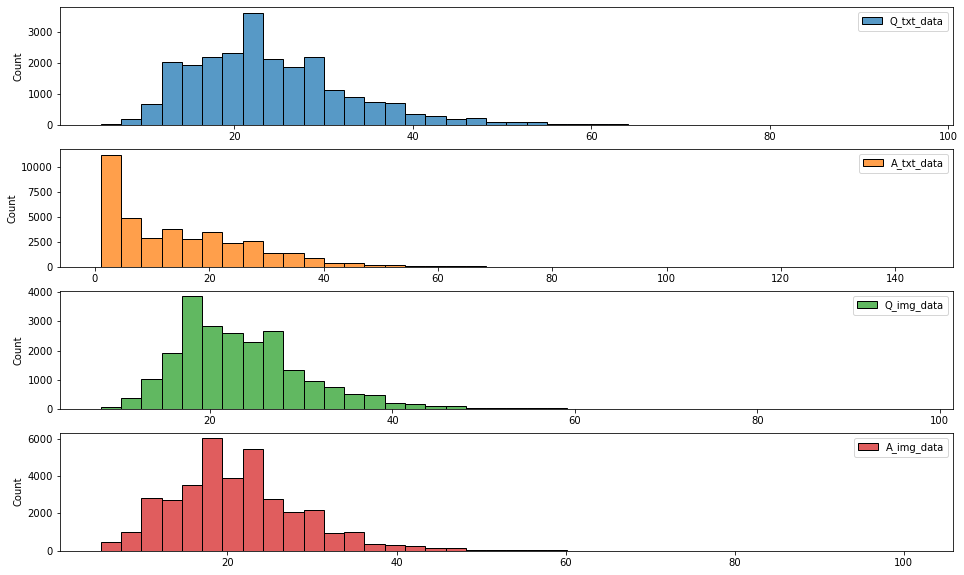

In [4]:
### Comparison of length distribution of snippets: 
# with pos snippets || with neg snippets for img data || with neg snippets for txt data
snippet_lengths = {'Q_txt_data': [], 'A_txt_data': [], 'Q_img_data': [], 'A_img_data': []}
for k in txt_dataset:
    snippet_lengths['Q_txt_data'].append(len(tokenizer.tokenize(txt_dataset[k]['Q'])))
    snippet_lengths['A_txt_data'].extend([len(tokenizer.tokenize(a)) for a in txt_dataset[k]['A']])
for k in img_dataset:
    snippet_lengths['Q_img_data'].append(len(tokenizer.tokenize(img_dataset[k]['Q'])))
    snippet_lengths['A_img_data'].extend([len(tokenizer.tokenize(a)) for a in img_dataset[k]['A']])
        
for k in snippet_lengths:
    print(k, len(snippet_lengths[k]))
for k in snippet_lengths:
    print(k, np.mean(snippet_lengths[k]), np.std(snippet_lengths[k]))
    
colors = sns.color_palette("tab10")
fig, axes = plt.subplots(4, 1, sharex=False, figsize=(16,10))
for i, k, color in zip(range(4), list(snippet_lengths.keys()), colors[:4]):
    ax = axes[i]
    #ax.set(yscale="log")
    sns.histplot(snippet_lengths[k], ax=ax, kde=False, bins=40, label=k, color=color)
    ax.legend()

In [ ]:
Q_txt_data 25091
A_txt_data 45956
Q_img_data 25392
A_img_data 57297
Q_txt_data 23.46602367382727 9.276406800861304
A_txt_data 15.714161371746888 13.685776848253361
Q_img_data 22.71195652173913 7.043431433240292
A_img_data 20.377401958217707 7.632208562214467

In [5]:
print("\nImg data, num(img_posFacts): ")
x = [len(img_dataset[k]['img_posFacts']) for k in img_dataset]
print(Counter(x))
print(np.mean(x), np.max(x), np.min(x))

print("\nImg data, num(img_negFacts): ")
x = [len(img_dataset[k]['img_negFacts']) for k in img_dataset]
print(Counter(x))
print(np.mean(x), np.max(x), np.min(x))

print("\nImg data, num(txt_negFacts): ")
x = [len(img_dataset[k]['txt_negFacts']) for k in img_dataset]
print(Counter(x))
print(np.mean(x), np.max(x), np.min(x))


Img data, num(img_posFacts): 
Counter({1: 12588, 2: 9835})
1.4386121393212326 2 1

Img data, num(img_negFacts): 
Counter({16: 21403, 13: 704, 12: 89, 15: 74, 14: 71, 11: 62, 7: 11, 10: 4, 8: 3, 9: 2})
15.859296258306204 16 7

Img data, num(txt_negFacts): 
Counter({16: 20622, 0: 134, 13: 130, 14: 120, 10: 119, 15: 119, 12: 118, 1: 118, 8: 115, 6: 113, 11: 113, 2: 106, 5: 104, 7: 104, 9: 97, 4: 96, 3: 95})
15.326851893145431 16 0


In [6]:
print("\ntxt data, num(txt_posFacts): ")
x = [len(txt_dataset[k]['txt_posFacts']) for k in txt_dataset]
print(Counter(x))
print(np.mean(x), np.max(x), np.min(x))

print("\ntxt data, num(img_negFacts): ")
x = [len(txt_dataset[k]['img_negFacts']) for k in txt_dataset]
print(Counter(x))
print(np.mean(x), np.max(x), np.min(x))

print("\ntxt data, num(txt_negFacts): ")
x = [len(txt_dataset[k]['txt_negFacts']) for k in txt_dataset]
print(Counter(x))
print(np.mean(x), np.max(x), np.min(x))


txt data, num(txt_posFacts): 
Counter({2: 23442, 3: 852, 4: 45, 1: 3, 5: 1})
2.0386969560037795 5 1

txt data, num(img_negFacts): 
Counter({16: 13773, 5: 898, 6: 840, 7: 783, 1: 759, 8: 748, 9: 723, 2: 691, 3: 690, 10: 672, 4: 637, 11: 632, 12: 550, 13: 549, 14: 530, 15: 506, 0: 362})
12.202604444809596 16 0

txt data, num(txt_negFacts): 
Counter({16: 19109, 10: 482, 8: 479, 7: 472, 9: 467, 13: 465, 11: 442, 12: 438, 6: 438, 15: 430, 5: 427, 14: 412, 4: 226, 3: 54, 2: 2})
14.629133631844883 16 2


In [7]:
img_topics = Counter([img_dataset[k]['topic'] for k in img_dataset])
print(img_topics.most_common(20))

[('Other', 2047), ('streets', 2015), ('plaza', 1171), ('mushroom', 738), ('downtown', 715), ('bird', 688), ('car', 621), ('tourist attractions', 552), ('vista', 533), ('civic center', 516), ('Christ Church Cathedral', 495), ('public art', 486), ('world expo pavilion', 467), ('tech institute', 460), ('museum', 453), ('flora', 442), ('Neoclassicism art', 433), ('strange architecture', 413), ('modern artwork', 412), ('college libraries', 410)]


pos_imgs 32258
neg_imgs_for_img 355613
neg_imgs_for_txt 297048
pos_imgs 12.284735569471138 7.779889579614249
neg_imgs_for_img 12.37771397558582 7.684564784523407
neg_imgs_for_txt 16.264122296733188 14.94513553476711


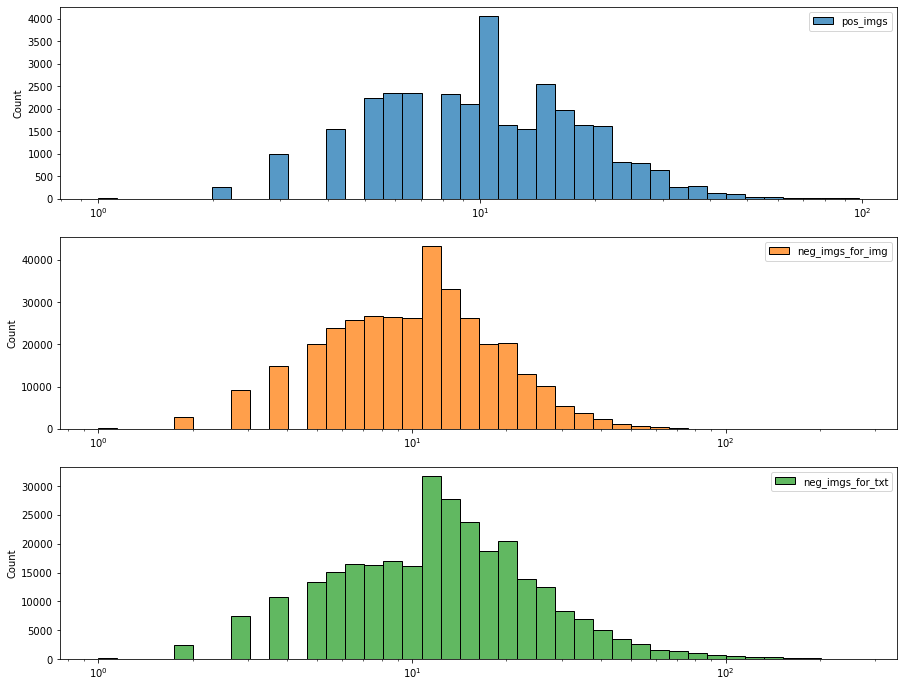

In [8]:
### Comparison of length distribution of img captions: 
# with pos imgs || with neg imgs for img data || with neg imgs for txt data
cap_lengths = {'pos_imgs': [], 'neg_imgs_for_img': [], 'neg_imgs_for_txt': []}
for k in img_dataset:
    for i in img_dataset[k]['img_posFacts']:
        cap_lengths['pos_imgs'].append(len(tokenizer.tokenize(i['caption'].strip())))
    for i in img_dataset[k]['img_negFacts']:
        cap_lengths['neg_imgs_for_img'].append(len(tokenizer.tokenize(i['caption'].strip())))
for k in txt_dataset:
    for i in txt_dataset[k]['img_negFacts']:
        cap_lengths['neg_imgs_for_txt'].append(len(tokenizer.tokenize(i['caption'].strip())))
        
for k in cap_lengths:
    print(k, len(cap_lengths[k]))
for k in cap_lengths:
    print(k, np.mean(cap_lengths[k]), np.std(cap_lengths[k]))

colors = sns.color_palette("tab10")
fig, axes = plt.subplots(3, 1, sharex=False, figsize=(15,12))
for i, k, color in zip(range(3), list(cap_lengths.keys()), colors[:3]):
    ax = axes[i]
    ax.set(xscale="log")
    sns.histplot(cap_lengths[k], ax=ax, kde=False, bins=40, label=k, color=color)
    ax.legend()

pos_snippets 49628
neg_snippets_for_img 343674
neg_snippets_for_txt 356117
pos_snippets 65.21256145724188 19.347038651791905
neg_snippets_for_img 49.76683426735802 15.334392825559785
neg_snippets_for_txt 53.71806456866704 17.5997685882277


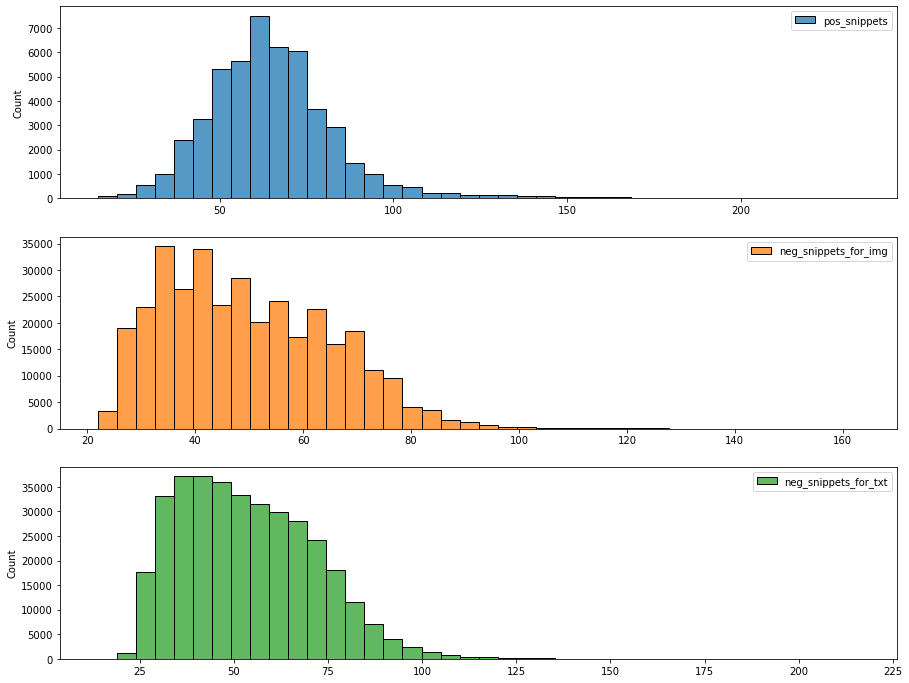

In [9]:
### Comparison of length distribution of snippets: 
# with pos snippets || with neg snippets for img data || with neg snippets for txt data
snippet_lengths = {'pos_snippets': [], 'neg_snippets_for_img': [], 'neg_snippets_for_txt': []}
for k in txt_dataset:
    for f in txt_dataset[k]['txt_posFacts']:
        snippet_lengths['pos_snippets'].append(len(tokenizer.tokenize(f['fact'])))
    for f in txt_dataset[k]['txt_negFacts']:
        snippet_lengths['neg_snippets_for_txt'].append(len(tokenizer.tokenize(f['fact'])))
for k in img_dataset:
    for f in img_dataset[k]['txt_negFacts']:
        snippet_lengths['neg_snippets_for_img'].append(len(tokenizer.tokenize(f['fact'])))
        
for k in snippet_lengths:
    print(k, len(snippet_lengths[k]))
for k in snippet_lengths:
    print(k, np.mean(snippet_lengths[k]), np.std(snippet_lengths[k]))
    
colors = sns.color_palette("tab10")
fig, axes = plt.subplots(3, 1, sharex=False, figsize=(15,12))
for i, k, color in zip(range(3), list(snippet_lengths.keys()), colors[:3]):
    ax = axes[i]
    #ax.set(yscale="log")
    sns.histplot(snippet_lengths[k], ax=ax, kde=False, bins=40, label=k, color=color)
    ax.legend()

In [9]:
img_dataset['0'].keys()

dict_keys(['Q', 'A', 'Qtype', 'topic', 'split', 'Qcate', 'Guid', 'word_lists', 'Keywords_A', 'img_posFacts', 'img_negFacts', 'txt_negFacts'])

### Filter Lexical Overlap Baseline

In [17]:
def compute_retrieval_metrics(pred, gth):
    common = len(set(pred).intersection(gth))
    RE = common / len(gth)
    PR = common / len(pred)
    F1 = 2*PR*RE / (PR + RE + 1e-5)
    return F1, RE, PR

# For the purpose of measuring token-level overlap
### Processing: only did stopwords removal + tokenization
pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')

def compute_vqa_metrics_for_filter_lexical_baseline(cands, a):
    if len(cands) == 0: return (0,0,0)
    remove_stop_a = pattern.sub('', a)
    bow_a = tokenizer.tokenize(remove_stop_a) #normalize_text(a).split()
    
    F1 = []
    EM = 0
    RE = []
    PR = []
    for c in cands:
        remove_stop_c = pattern.sub('', c)
        bow_c = tokenizer.tokenize(remove_stop_c) #normalize_text(c).split()
        cand_length = len(bow_c)
        if bow_c == bow_a:
            EM = 1
        common = Counter(bow_a) & Counter(bow_c)
        num_same = sum(common.values())
        if num_same == 0:
            return (0,0,0,0,0, cand_length)
        precision = 1.0 * num_same / len(bow_c)
        recall = 1.0 * num_same / len(bow_a)
        RE.append(recall)
        PR.append(precision)

        f1 = 2*precision*recall / (precision + recall + 1e-5)
        F1.append(f1)
    
    PR_avg = np.mean(PR)
    RE_avg = np.mean(RE)
    F1_avg = np.mean(F1)
    F1_max = np.max(F1)
    return (F1_avg, F1_max, EM, RE_avg, PR_avg, cand_length)

In [105]:
# For each sample, compute overlap metrics between Q and all facts respectively
# Only for testing set

guid2posMetrics = {}
guid2negMetrics = {}
zero_pos = 0
count = 0
counter = []
for k in txt_dataset:
    if not txt_dataset[k]['split'] == 'test': continue
    count += 1
    if count%1000 == 0: print(k)
    q = txt_dataset[k]['Q']
    guid = txt_dataset[k]['Guid']
    guid2posMetrics[guid] = {'F1': [], 'RE': [], 'PR': [], 'lcs_q': [], 'lcs_f': []}
    guid2negMetrics[guid] = {'F1': [], 'RE': [], 'PR': [], 'lcs_q': [], 'lcs_f': []} #, 'RE_aug_by_len_bonus': []}


    txt_posFacts = txt_dataset[k]['txt_posFacts']
    if len(txt_posFacts) == 0: 
        zero_pos += 1
        continue
    for f in txt_posFacts:
        F1, _, __, RE, PR, cand_length = compute_vqa_metrics_for_filter_lexical_baseline([f['fact']], q)
        lcs = pylcs.lcs2(q, f['fact'])
        lcs_f = lcs / len(f['fact'])
        lcs_q = lcs / len(q)
        guid2posMetrics[guid]['F1'].append(F1)
        guid2posMetrics[guid]['RE'].append(RE)
        guid2posMetrics[guid]['PR'].append(PR)
        guid2posMetrics[guid]['lcs_q'].append(lcs_q)
        guid2posMetrics[guid]['lcs_f'].append(lcs_f)
    
    txt_negFacts = txt_dataset[k]['txt_negFacts']
    counter.append(len(txt_negFacts))
    for d in txt_negFacts:
        F1, _, __, RE, PR, cand_length = compute_vqa_metrics_for_filter_lexical_baseline([d['fact']], q)
        lcs = pylcs.lcs2(q, d['fact'])
        lcs_f = lcs / len(d['fact'])
        lcs_q = lcs / len(q)
        guid2negMetrics[guid]['F1'].append(F1)
        guid2negMetrics[guid]['RE'].append(RE)
        guid2negMetrics[guid]['PR'].append(PR)
        guid2negMetrics[guid]['lcs_q'].append(lcs_q)
        guid2negMetrics[guid]['lcs_f'].append(lcs_f)
        
        #len_bonus = (cand_length - 45) * 0.01 if cand_length > 45 else 0.0
        #guid2negMetrics[guid]['RE_aug_by_len_bonus'].append(RE + len_bonus)

assert set(guid2posMetrics.keys()) == set(guid2negMetrics.keys())
print(zero_pos)
print(count)
print(Counter(counter))

4020
13151
19050
24885
0
4076
Counter({16: 3180, 10: 88, 13: 83, 14: 82, 12: 80, 15: 79, 11: 79, 7: 77, 9: 74, 6: 72, 8: 70, 5: 64, 4: 42, 3: 6})


In [106]:
# For each sample, compute overlap metrics between Q and all facts respectively
# txt data, and their negative imgs.
# Only for testing set

guid2negImgMetrics = {}
count = 0
counter = []
for k in txt_dataset:
    if not txt_dataset[k]['split'] == 'test': continue
    count += 1
    if count%1000 == 0: print(count)
    q = txt_dataset[k]['Q']
    guid = txt_dataset[k]['Guid']
    guid2negImgMetrics[guid] = {'F1': [], 'RE': [], 'PR': [], 'lcs_q': [], 'lcs_f': []} #, 'RE_aug_by_len_bonus': []}

    img_negFacts = txt_dataset[k]['img_negFacts']
    counter.append(len(img_negFacts))
    for d in img_negFacts:
        F1, _, __, RE, PR, cand_length = compute_vqa_metrics_for_filter_lexical_baseline([d['caption']], q)
        lcs = pylcs.lcs2(q, d['caption'])
        lcs_f = lcs / len(d['caption'])
        lcs_q = lcs / len(q)
        guid2negImgMetrics[guid]['F1'].append(F1)
        guid2negImgMetrics[guid]['RE'].append(RE)
        guid2negImgMetrics[guid]['PR'].append(PR)
        guid2negImgMetrics[guid]['lcs_q'].append(lcs_q)
        guid2negImgMetrics[guid]['lcs_f'].append(lcs_f)
        
        #len_bonus = (cand_length - 10) * (-0.015) if cand_length > 10 else 0.0
        #guid2negImgMetrics[guid]['RE_aug_by_len_bonus'].append(RE + len_bonus)
        
assert set(guid2negMetrics.keys()) == set(guid2negImgMetrics.keys())
print(count)
print(Counter(counter))

1000
2000
3000
4000
4076
Counter({16: 2276, 5: 157, 8: 139, 1: 138, 6: 125, 2: 123, 7: 118, 3: 117, 10: 114, 9: 112, 11: 110, 13: 107, 4: 104, 15: 98, 12: 97, 14: 89, 0: 52})


In [107]:
# For each sample, compute overlap metrics between Q and all facts respectively
# img data, and their negative snippets. 
# Only for testing set

guid2negMetrics_img_data = {}
count = 0
counter = []

for k in img_dataset:
    if not img_dataset[k]['split'] == 'test': continue
    count += 1
    if count%1000 == 0: print(count)
    q = img_dataset[k]['Q']
    guid = img_dataset[k]['Guid']
    guid2negMetrics_img_data[guid] = {'F1': [], 'RE': [], 'PR': [], 'lcs_q': [], 'lcs_f': []} #, 'RE_aug_by_len_bonus': []}
    
    txt_negFacts = img_dataset[k]['txt_negFacts']
    counter.append(len(txt_negFacts))
    for d in txt_negFacts:
        F1, _, __, RE, PR, cand_length = compute_vqa_metrics_for_filter_lexical_baseline([d['fact']], q)
        lcs = pylcs.lcs2(q, d['fact'])
        lcs_f = lcs / len(d['fact'])
        lcs_q = lcs / len(q)
        guid2negMetrics_img_data[guid]['F1'].append(F1)
        guid2negMetrics_img_data[guid]['RE'].append(RE)
        guid2negMetrics_img_data[guid]['PR'].append(PR)
        guid2negMetrics_img_data[guid]['lcs_q'].append(lcs_q)
        guid2negMetrics_img_data[guid]['lcs_f'].append(lcs_f)
        
        #len_bonus = (cand_length - 43) * 0.02 if cand_length > 43 else 0.0
        #guid2negMetrics_img_data[guid]['RE_aug_by_len_bonus'].append(RE + len_bonus)

print(count)
print(Counter(counter))

1000
2000
3000
3464
Counter({16: 3162, 0: 24, 2: 24, 6: 24, 10: 23, 4: 23, 13: 22, 11: 21, 1: 21, 3: 18, 7: 17, 8: 17, 9: 14, 14: 14, 12: 14, 5: 13, 15: 13})


In [108]:
# For each sample, compute overlap metrics between Q and all facts respectively
# img data, and their negative imgs. 
# Prefer shorter neg img captions

guid2negImgMetrics_img_data = {}
guid2posImgMetrics_img_data = {}
count = 0
counter = []
for k in img_dataset:
    if not img_dataset[k]['split'] == 'test': continue
    count += 1
    if count%1000 == 0: print(count)
    q = img_dataset[k]['Q']
    guid = img_dataset[k]['Guid']
    guid2posImgMetrics_img_data[guid] = {'F1': [], 'RE': [], 'PR': [], 'lcs_q': [], 'lcs_f': []}
    guid2negImgMetrics_img_data[guid] = {'F1': [], 'RE': [], 'PR': [], 'lcs_q': [], 'lcs_f': []} #, 'RE_aug_by_len_bonus': []}
    
    img_posFacts = img_dataset[k]['img_posFacts']
    for d in img_posFacts:
        F1, _, __, RE, PR, cand_length = compute_vqa_metrics_for_filter_lexical_baseline([d['caption']], q)
        lcs = pylcs.lcs2(q, d['caption'])
        lcs_f = lcs / len(d['caption'])
        lcs_q = lcs / len(q)
        guid2posImgMetrics_img_data[guid]['F1'].append(F1)
        guid2posImgMetrics_img_data[guid]['RE'].append(RE)
        guid2posImgMetrics_img_data[guid]['PR'].append(PR)
        guid2posImgMetrics_img_data[guid]['lcs_q'].append(lcs_q)
        guid2posImgMetrics_img_data[guid]['lcs_f'].append(lcs_f)
        
    img_negFacts = img_dataset[k]['img_negFacts']
    counter.append(len(img_negFacts))
    for d in img_negFacts:
        F1, _, __, RE, PR, cand_length = compute_vqa_metrics_for_filter_lexical_baseline([d['caption']], q)
        lcs = pylcs.lcs2(q, d['caption'])
        lcs_f = lcs / len(d['caption'])
        lcs_q = lcs / len(q)
        guid2negImgMetrics_img_data[guid]['F1'].append(F1)
        guid2negImgMetrics_img_data[guid]['RE'].append(RE)
        guid2negImgMetrics_img_data[guid]['PR'].append(PR)
        guid2negImgMetrics_img_data[guid]['lcs_q'].append(lcs_q)
        guid2negImgMetrics_img_data[guid]['lcs_f'].append(lcs_f)
        
        #len_bonus = (cand_length - 10) * (-0.01) if cand_length > 10 else 0.0
        #guid2negImgMetrics_img_data[guid]['RE_aug_by_len_bonus'].append(RE + len_bonus)
        
assert set(guid2negImgMetrics_img_data.keys()) == set(guid2negMetrics_img_data.keys()) == set(guid2posImgMetrics_img_data.keys())
print(count)
print(Counter(counter))

1000
2000
3000
3464
Counter({16: 3309, 13: 107, 12: 16, 14: 11, 11: 11, 15: 8, 7: 1, 10: 1})


In [60]:
guid = random.sample(list(guid2negMetrics.keys()), 1)[0]
print(guid2posMetrics[guid]['RE'])
print(guid2negMetrics[guid]['RE'])
#print(guid2negMetrics_img_data[guid]['RE'])

[0.6, 0.3333333333333333]
[0.4666666666666667, 0.3333333333333333, 0.26666666666666666, 0.26666666666666666, 0.3333333333333333, 0.3333333333333333, 0.13333333333333333, 0.26666666666666666, 0.26666666666666666, 0.06666666666666667, 0.13333333333333333, 0.2, 0.2, 0.2, 0.2, 0.2]


In [117]:
# randomly break ties
def argmax(n, L):
    l = copy.deepcopy(L)
    assert n <= len(l)
    result = []
    while len(result) < n:
        m = np.max(l)
        idx = random.choice([i for i in range(len(l)) if l[i] == m])
        result.append(idx)
        l[idx] = - 10000
    return result

In [132]:
# Performance of top2<m> lexical overlap baseline, txt data, known modality 
assert len(guid2posMetrics) == len(guid2negMetrics)
print(len(guid2posMetrics))
for m in ['F1', 'RE', 'PR', 'lcs_q', 'lcs_f']:
    F1s = []
    REs = []
    PRs = []
    print(m)
    for i in range(10):
        for guid in guid2posMetrics:
            f_scores = guid2posMetrics[guid][m]
            all_scores = np.array((f_scores + guid2negMetrics[guid][m])[:16])
            pred = argmax(2, all_scores)
            gth = range(len(guid2posMetrics[guid][m]))
            F1, RE, PR = compute_retrieval_metrics(pred, gth)
            F1s.append(F1)
            REs.append(RE)
            PRs.append(PR)
    print('   F1 = ', np.mean(F1s))
    print('   RE = ', np.mean(REs))
    print('   PR = ', np.mean(PRs))

4076
F1
   F1 =  0.4517710180529249
   RE =  0.44996319921491656
   PR =  0.45456329735034345
RE
   F1 =  0.6016409849768525
   RE =  0.5989614000654235
   PR =  0.6057531894013739
PR
   F1 =  0.3575206790731267
   RE =  0.35611301929996725
   PR =  0.3596908734052993
lcs_q
   F1 =  0.5794331259728277
   RE =  0.5767255479228001
   PR =  0.5835868498527969
lcs_f
   F1 =  0.4209731046715239
   RE =  0.41918547595682043
   PR =  0.42372423945044163


In [133]:
# Performance of top2<m> lexical overlap baseline, txt data, UNknown modality 
assert len(guid2posMetrics) == len(guid2negMetrics) == len(guid2negImgMetrics)
print(len(guid2posMetrics))
for m in ['F1', 'RE', 'PR', 'lcs_q', 'lcs_f']:
    F1s = []
    REs = []
    PRs = []
    print(m)
    for i in range(10):
        for guid in guid2posMetrics:
            f_scores = guid2posMetrics[guid][m]
            all_scores = np.array((f_scores + guid2negMetrics[guid][m])[:16] + guid2negImgMetrics[guid][m])
            pred = argmax(2, all_scores)
            gth = range(len(guid2posMetrics[guid][m]))
            F1, RE, PR = compute_retrieval_metrics(pred, gth)
            F1s.append(F1)
            REs.append(RE)
            PRs.append(PR)
    print('   F1 = ', np.mean(F1s))
    print('   RE = ', np.mean(REs))
    print('   PR = ', np.mean(PRs))

4076
F1
   F1 =  0.33480829663626605
   RE =  0.3336481844946025
   PR =  0.33661678115799804
RE
   F1 =  0.5847699360807259
   RE =  0.5821904645076873
   PR =  0.5887266928361138
PR
   F1 =  0.13588936444499666
   RE =  0.13541871115472684
   PR =  0.13662904808635917
lcs_q
   F1 =  0.548042211506923
   RE =  0.5456370624795551
   PR =  0.5517419038272816
lcs_f
   F1 =  0.0998052998561562
   RE =  0.09957065750736015
   PR =  0.1001594700686948


In [134]:
# Performance of top2<m> lexical overlap baseline, img data, known modality 
assert len(guid2posImgMetrics_img_data) == len(guid2negImgMetrics_img_data)
print(len(guid2posImgMetrics_img_data))
for m in ['F1', 'RE', 'PR', 'lcs_q', 'lcs_f']:
    F1s = []
    REs = []
    PRs = []
    print(m)
    for i in range(10):
        for guid in guid2posImgMetrics_img_data:
            f_scores = guid2posImgMetrics_img_data[guid][m]
            all_scores = np.array(f_scores + guid2negImgMetrics_img_data[guid][m])[:16]
            try: pred = argmax(2, all_scores)
            except: print(all_scores)
            gth = range(len(guid2posImgMetrics_img_data[guid][m]))
            F1, RE, PR = compute_retrieval_metrics(pred, gth)
            F1s.append(F1)
            REs.append(RE)
            PRs.append(PR)
    print('   F1 = ', np.mean(F1s))
    print('   RE = ', np.mean(REs))
    print('   PR = ', np.mean(PRs))

3464
F1
   F1 =  0.5621641517313652
   RE =  0.7144197459584296
   PR =  0.48604214780600463
RE
   F1 =  0.5152725564806033
   RE =  0.6572892609699769
   PR =  0.44426963048498846
PR
   F1 =  0.5397912936187003
   RE =  0.6882361431870669
   PR =  0.465574480369515
lcs_q
   F1 =  0.4977447683093919
   RE =  0.6336027713625866
   PR =  0.42982101616628177
lcs_f
   F1 =  0.5122510148459529
   RE =  0.6551241339491917
   PR =  0.4408198614318707


In [135]:
# Performance of top2<m> lexical overlap baseline, img data, UNknown modality 
assert len(guid2posImgMetrics_img_data) == len(guid2negMetrics_img_data) == len(guid2negImgMetrics_img_data)
print(len(guid2posImgMetrics_img_data))
for m in ['F1', 'RE', 'PR', 'lcs_q', 'lcs_f']:
    F1s = []
    REs = []
    PRs = []
    print(m)
    for i in range(10):
        for guid in guid2posImgMetrics_img_data:
            f_scores = guid2posImgMetrics_img_data[guid][m]
            all_scores = np.array((f_scores + guid2negImgMetrics_img_data[guid][m])[:16] + guid2negMetrics_img_data[guid][m])
            pred = all_scores.argsort()[-2:][::-1]
            gth = range(len(guid2posImgMetrics_img_data[guid][m]))
            F1, RE, PR = compute_retrieval_metrics(pred, gth)
            F1s.append(F1)
            REs.append(RE)
            PRs.append(PR)
    print('   F1 = ', np.mean(F1s))
    print('   RE = ', np.mean(REs))
    print('   PR = ', np.mean(PRs))

3464
F1
   F1 =  0.46405558942060854
   RE =  0.5907909930715936
   PR =  0.4006928406466513
RE
   F1 =  0.2440801780356611
   RE =  0.3171189376443418
   PR =  0.2075635103926097
PR
   F1 =  0.5158259000777442
   RE =  0.6551674364896074
   PR =  0.4461605080831409
lcs_q
   F1 =  0.2667897966537974
   RE =  0.3384815242494226
   PR =  0.23094688221709006
lcs_f
   F1 =  0.5179428615230636
   RE =  0.6618071593533488
   PR =  0.4460161662817552


In [ ]:
# lcs2: longest common substring (should not skip characters)